# CEBD1260: Full Machine Learning Pipeline
*by Hamza Benhmani & Pierre-Olivier Bonin*

> In this notebook, we use our custom function `utils.py` to aggregate, merge, and fill missing values of the Credit Risk datasets.
> Please look [here](https://github.com/gzork/the-big-short/blob/main/utils.py) for the function.

In [52]:
import lightgbm as lgb
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import ntpath
import operator
import re
from utils import *
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from sklearn.metrics import roc_auc_score

data_dir = "D:/Documents/Pierre-Olivier/CEBD1260/Datasets/"

In [5]:
%%time
names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

dfs["application_train"].shape

Wall time: 26.7 s


(307511, 122)

In [6]:
def train_model():
    # main_df = preprocessing_data() we remove this since we've already done the preprocessing
    # building model
    model_lgb = lgb.LGBMClassifier(
        n_jobs=6,
        n_estimators=100000,
        boost_from_average='false',
        learning_rate=0.01,
        num_leaves=64,
        num_threads=4,
        max_depth=-1,
        tree_learner="serial",
        feature_fraction=0.7,
        bagging_freq=5,
        bagging_fraction=0.7,
        min_data_in_leaf=100,
        silent=-1,
        verbose=-1,
        max_bin=255,
        bagging_seed=11,
    )

    features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
    X = main_df[features]
    y = main_df['TARGET']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)

    model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc', verbose=200,
                  early_stopping_rounds=300)
    y_valid_lgb = model_lgb.predict_proba(X_valid, num_iteration=model_lgb.best_iteration_)[:, 1]

## Benchmark Model: performance is 76.3% correct prediction on 1s

In [7]:
main_df = dfs['application_train']
na_catfiller(main_df)
na_numfiller(main_df)
main_df = str_catencoder(main_df)

train_model()

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.756664	training's binary_logloss: 0.272206	valid_1's auc: 0.744845	valid_1's binary_logloss: 0.275158
[400]	training's auc: 0.772295	training's binary_logloss: 0.244296	valid_1's auc: 0.751818	valid_1's binary_logloss: 0.250647
[600]	training's auc: 0.78898	training's binary_logloss: 0.237393	valid_1's auc: 0.757569	valid_1's binary_logloss:

## Aggregations and Merging

In [8]:
%%time
bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
bureau_balance.reset_index(level=0, inplace=True)
bureau_balance

Wall time: 1min 4s


,SK_ID_BUREAU,STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF,STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF
0,5001709,NaN,NaN,NaN,NaN,NaN,NaN,85.0,10.0
1,5001710,5.0,NaN,NaN,NaN,NaN,NaN,47.0,33.0
2,5001711,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,5001712,9.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN
4,5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...,...
817390,6842884,8.0,NaN,NaN,NaN,NaN,NaN,19.0,27.0
817391,6842885,11.0,NaN,NaN,NaN,NaN,11.0,NaN,NaN
817392,6842886,7.0,NaN,NaN,NaN,NaN,NaN,24.0,NaN
817393,6842887,5.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN


In [9]:
%%time
dfs["bureau"] = dfs["bureau"].merge(bureau_balance,on='SK_ID_BUREAU',how='left')
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

Wall time: 1.6 s


In [10]:
%%time
aggr_dicts = {
    "POS_CASH_balance" : {
        'SK_DPD':['max','std','median'],
        'SK_DPD_DEF':['max','std','median'],
    },
    "credit_card_balance" : {
        'AMT_BALANCE':['max','std','median'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max','std','median'],
        'AMT_PAYMENT_CURRENT':['max','std','median'],
        'AMT_RECEIVABLE_PRINCIPAL':['max','std','median'],
        'AMT_RECIVABLE':['max','std','median'],
        'CNT_INSTALMENT_MATURE_CUM':['max','std','median'],
        'SK_DPD':['max','std','median'],
        'SK_DPD_DEF':['max','std','median'],
    },
    "previous_application" : {
        'AMT_ANNUITY':['max','std','median'],
        'AMT_APPLICATION':['max','std','median'],
        'AMT_CREDIT':['max','std','median'],
        'AMT_DOWN_PAYMENT':['max','std','median'],
        'AMT_GOODS_PRICE':['max','std','median'],
        'RATE_DOWN_PAYMENT':['max','std','median'],
        'RATE_INTEREST_PRIMARY':['max','std','median'],
        'RATE_INTEREST_PRIVILEGED':['max','std','median'],
        'DAYS_DECISION':['max','std','median'],
    },
    "installments_payments" : {
        'AMT_INSTALMENT':['max','std','median'],
        'AMT_PAYMENT':['max','std','median'],
    },
    "bureau" : {
        'SK_ID_BUREAU':['nunique'],
        'CREDIT_ACTIVE':['nunique'],
        'CREDIT_CURRENCY':['nunique'],
        'DAYS_CREDIT':[lambda x: (x.max()-x.min(), "max_min_diff")],
        'CREDIT_DAY_OVERDUE':['sum', 'median'],
        'DAYS_CREDIT_ENDDATE':['std'],
        'DAYS_ENDDATE_FACT':['std'],
        'AMT_CREDIT_MAX_OVERDUE':['max'],
        'CNT_CREDIT_PROLONG':['sum', 'median'],
        'AMT_CREDIT_SUM':['sum', 'median'],
        'AMT_CREDIT_SUM_DEBT':['sum', 'median'],
        'AMT_CREDIT_SUM_LIMIT':['sum', 'median'],
        'AMT_CREDIT_SUM_OVERDUE':['sum', 'median'],
        'CREDIT_TYPE':['nunique'],
        'DAYS_CREDIT_UPDATE':['mean'],
        'AMT_ANNUITY':['sum', 'median'],
        'STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
    }
}

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

main_df.shape, main_df.columns.tolist()

Wall time: 24.4 s


((307511, 216),
 ['SK_ID_CURR',
  'TARGET',
  'NAME_CONTRACT_TYPE',
  'CODE_GENDER',
  'FLAG_OWN_CAR',
  'FLAG_OWN_REALTY',
  'CNT_CHILDREN',
  'AMT_INCOME_TOTAL',
  'AMT_CREDIT',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'NAME_TYPE_SUITE',
  'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE',
  'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_BIRTH',
  'DAYS_EMPLOYED',
  'DAYS_REGISTRATION',
  'DAYS_ID_PUBLISH',
  'OWN_CAR_AGE',
  'FLAG_MOBIL',
  'FLAG_EMP_PHONE',
  'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE',
  'FLAG_PHONE',
  'FLAG_EMAIL',
  'OCCUPATION_TYPE',
  'CNT_FAM_MEMBERS',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'WEEKDAY_APPR_PROCESS_START',
  'HOUR_APPR_PROCESS_START',
  'REG_REGION_NOT_LIVE_REGION',
  'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION',
  'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY',
  'LIVE_CITY_NOT_WORK_CITY',
  'ORGANIZATION_TYPE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'APAR

In [11]:
main_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_median,bureau_STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,7.5,3.625,0.0,0.0,0.0,6.0,7.625,5.625
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000,6.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000,6.000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000,6.000


In [12]:
main_df.isnull().sum().sum()/216

45378.523148148146

In [13]:
na_numfiller(main_df, aggregation_func="median")

In [14]:
main_df.isnull().sum().sum()

0

In [15]:
na_catfiller(main_df)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_AMT_ANNUITY_sum,bureau_AMT_ANNUITY_median,bureau_STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF_mean,bureau_STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF_mean
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,7.5,3.625,0.0,0.0,0.0,6.0,7.625000,5.625000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,8.0,0.000,0.0,0.0,0.0,6.0,22.000000,6.000000
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,175108.5,58369.5,12.0,0.000,0.0,0.0,0.0,6.0,19.000000,10.250000
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,7.0,0.000,0.0,0.0,0.0,6.0,28.000000,6.000000


In [16]:
main_df.isnull().sum().sum()

0

In [17]:
optimize_inttypes(main_df, specify="int32")

Memory usage of dataframe is 0.533839 GB
Total initial memory used for selected dataframe is: 0.53GB
Memory usage of dataframe is 0.483407 GB
Total memory currently used for selected dataframe is: 0.48GB


In [18]:
optimize_floattypes(main_df, specify="float32")

Memory usage of dataframe is 0.483407 GB
Total initial memory used for selected dataframe is: 0.48GB
Memory usage of dataframe is 0.287830 GB
Total memory currently used for selected dataframe is: 0.29GB


In [19]:
main_df.shape

(307511, 216)

In [20]:
main_df = str_catencoder(main_df)

In [21]:
main_df.shape

(307511, 271)

In [22]:
main_df.isnull().sum().sum()

0

In [23]:
main_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stonebrick,WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_missing_data,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_missing_data
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,1,0,0,1,0,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0,0,0,1,0,0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0,0,1,0,0,1
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,0,0,1,0,0,1
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0,0,1,0,0,1


# Train-Test Split and Modelling using LightGBM

In [24]:
train_model()

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.766169	training's binary_logloss: 0.27075	valid_1's auc: 0.747004	valid_1's binary_logloss: 0.274813
[400]	training's auc: 0.786397	training's binary_logloss: 0.240447	valid_1's auc: 0.756313	valid_1's binary_logloss: 0.249327
[600]	training's auc: 0.806547	training's binary_logloss: 0.231496	valid_1's auc: 0.764936	valid_1's binary_logloss:

> Now we need to do more feature engineering to try to improve our model. I have targeted a few columns that are not currently in use and could be added:

    In previous_application:
    * NAME_CASH_LOAN_PURPOSE
    * NAME_CONTRACT_STATUS
    * CODE_REJECT_REASON
    * ... basically all of the potentially useful categorical features.


In [27]:
main_df.shape, main_df.isnull().sum().sum()

((307511, 271), 0)

### Try again, using a different threshold for the categorical features encoding (method_switch=50)

In [33]:
%%time

names = [re.sub('\.csv$', '', ntpath.basename(p)) for p in glob.glob(data_dir + "*.csv")]

dfs = {}
for df_name in names:
    dfs[df_name] = pd.read_csv(f"{data_dir}{df_name}.csv")

dfs["application_train"].shape

bureau_balance = dfs["bureau_balance"].reset_index().groupby(['SK_ID_BUREAU', 'STATUS'])['MONTHS_BALANCE'].aggregate(lambda x: x.max()-x.min()).unstack()
bureau_balance.columns = [f"{bureau_balance.columns.name}_{c}_MONTHS_BALANCE_MAX_MIN_DIFF" for c in bureau_balance.columns]
bureau_balance.reset_index(level=0, inplace=True)

dfs["bureau"] = dfs["bureau"].merge(bureau_balance,on='SK_ID_BUREAU',how='left')
for f in [f for f in dfs["bureau"].columns if dfs["bureau"][f].isnull().sum()>0]:
    dfs["bureau"][f] = dfs["bureau"][f].fillna(dfs["bureau"][f].median())

aggr_dicts = {
    "POS_CASH_balance" : {
        'SK_DPD':['max','std','median'],
        'SK_DPD_DEF':['max','std','median'],
    },
    "credit_card_balance" : {
        'AMT_BALANCE':['max','std','median'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max','std','median'],
        'AMT_PAYMENT_CURRENT':['max','std','median'],
        'AMT_RECEIVABLE_PRINCIPAL':['max','std','median'],
        'AMT_RECIVABLE':['max','std','median'],
        'CNT_INSTALMENT_MATURE_CUM':['max','std','median'],
        'SK_DPD':['max','std','median'],
        'SK_DPD_DEF':['max','std','median'],
    },
    "previous_application" : {
        'AMT_ANNUITY':['max','std','median'],
        'AMT_APPLICATION':['max','std','median'],
        'AMT_CREDIT':['max','std','median'],
        'AMT_DOWN_PAYMENT':['max','std','median'],
        'AMT_GOODS_PRICE':['max','std','median'],
        'RATE_DOWN_PAYMENT':['max','std','median'],
        'RATE_INTEREST_PRIMARY':['max','std','median'],
        'RATE_INTEREST_PRIVILEGED':['max','std','median'],
        'DAYS_DECISION':['max','std','median'],
    },
    "installments_payments" : {
        'AMT_INSTALMENT':['max','std','median'],
        'AMT_PAYMENT':['max','std','median'],
    },
    "bureau" : {
        'SK_ID_BUREAU':['nunique'],
        'CREDIT_ACTIVE':['nunique'],
        'CREDIT_CURRENCY':['nunique'],
        'DAYS_CREDIT':[lambda x: (x.max()-x.min(), "max_min_diff")],
        'CREDIT_DAY_OVERDUE':['sum', 'median'],
        'DAYS_CREDIT_ENDDATE':['std'],
        'DAYS_ENDDATE_FACT':['std'],
        'AMT_CREDIT_MAX_OVERDUE':['max'],
        'CNT_CREDIT_PROLONG':['sum', 'median'],
        'AMT_CREDIT_SUM':['sum', 'median'],
        'AMT_CREDIT_SUM_DEBT':['sum', 'median'],
        'AMT_CREDIT_SUM_LIMIT':['sum', 'median'],
        'AMT_CREDIT_SUM_OVERDUE':['sum', 'median'],
        'CREDIT_TYPE':['nunique'],
        'DAYS_CREDIT_UPDATE':['mean'],
        'AMT_ANNUITY':['sum', 'median'],
        'STATUS_0_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_1_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_2_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_3_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_4_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_5_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_C_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
        'STATUS_X_MONTHS_BALANCE_MAX_MIN_DIFF':['mean'],
    }
}

main_df = dfs["application_train"]
for table in aggr_dicts:
    main_df = merge_with_aggr(main_df, dfs[table], "SK_ID_CURR", aggr_dicts[table], table)

na_numfiller(main_df, aggregation_func="median")
optimize_inttypes(main_df, specify="int32")
optimize_floattypes(main_df, specify="float32")
main_df = str_catencoder(main_df, method_switch=50)

Memory usage of dataframe is 0.533839 GB
Total initial memory used for selected dataframe is: 0.53GB
Memory usage of dataframe is 0.483407 GB
Total memory currently used for selected dataframe is: 0.48GB
Memory usage of dataframe is 0.483407 GB
Total initial memory used for selected dataframe is: 0.48GB
Memory usage of dataframe is 0.287830 GB
Total memory currently used for selected dataframe is: 0.29GB
Wall time: 2min 17s


In [34]:
main_df.shape

(307511, 283)

In [35]:
train_model()

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=6 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.765242	training's binary_logloss: 0.270699	valid_1's auc: 0.745871	valid_1's binary_logloss: 0.274832
[400]	training's auc: 0.785652	training's binary_logloss: 0.240508	valid_1's auc: 0.756049	valid_1's binary_logloss: 0.249297
[600]	training's auc: 0.806509	training's binary_logloss: 0.231467	valid_1's auc: 0.765205	valid_1's binary_logloss

> This is actually worse than the previous version using `str_catencoder(main_df, method_switch=10)`. Let's try more feature engineering.

# KFold cross-validation & Feature Importance

In [48]:
# get X and y, X input, y target: this is total data set X and y
features = [f for f in main_df.columns if f not in ['SK_ID_CURR', 'TARGET']]
X = main_df[features]
y = main_df['TARGET']

#split out for some test set as if it is future unseen data, using train_test_split for now
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=10, test_size=0.1)
print(X_train.shape,X_test.shape,len(y_train),len(y_test))

# we reindex the objects
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

#define your lightgbm model by initializing parameters
model_lgb = lgb.LGBMClassifier(
            n_jobs=4,
            n_estimators=100000,
            boost_from_average='false',
            learning_rate=0.01,
            num_leaves=64,
            num_threads=4,
            max_depth=-1,
            tree_learner = "serial",
            feature_fraction = 0.7,
            bagging_freq = 5,
            bagging_fraction = 0.7,
            min_data_in_leaf=100,
            silent=-1,
            verbose=-1,
            max_bin = 255,
            bagging_seed = 11,
            )

#initialize KFold, we can use stratified KFold to keep the same imbalance ratio for target
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=10)

# Use KFold to train 5 models
auc_scores = [] # save auc score for each fold
models = [] #save model for each fold
for i, (train_idx,valid_idx) in enumerate(kf.split(X_train,y_train)):
    
    print('...... training {}th fold \n'.format(i+1))
    tr_X = X_train.loc[train_idx]
    tr_y = y_train.loc[train_idx]
    
    va_X = X_train.loc[valid_idx]
    va_y = y_train.loc[valid_idx]
    
    model = model_lgb # you need to initialize your lgb model at each loop, otherwise it will overwrite
    model.fit(tr_X, tr_y, eval_set=[(tr_X, tr_y), (va_X, va_y)], eval_metric = 'auc', verbose=500, early_stopping_rounds = 300)
    
    # calculate current auc after training the model
    pred_va_y = model.predict_proba(va_X,num_iteration=model.best_iteration_)[:,1]
    auc = roc_auc_score(va_y,pred_va_y)
    print('current best auc score is:{}'.format(auc))
    auc_scores.append(auc)
    models.append(model)

(276759, 281) (30752, 281) 276759 30752
...... training 1th fold 

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] num_threads is set=4, n_jobs=4 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 300 rounds
[500]	training's auc: 0.803367	training's binary_logloss: 0.233422	valid_1's auc: 0.766571	valid_1's binary_logloss: 0.244746
[1000]	training's auc: 0.850785	training's binary_logloss: 0.215092	valid_1's auc: 0.77588	valid_1's binary_logloss: 0.240782
[1500]	training's auc: 0.885313	training's binar

## Evaluate the models

In [49]:
print('the average mean auc is:{}'.format(np.mean(auc_scores)))

pred_test_1 = models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]
pred_test_2 = models[1].predict_proba(X_test,num_iteration=models[1].best_iteration_)[:,1]
pred_test_3 = models[2].predict_proba(X_test,num_iteration=models[2].best_iteration_)[:,1]
pred_test_4 = models[3].predict_proba(X_test,num_iteration=models[3].best_iteration_)[:,1]
pred_test_5 = models[4].predict_proba(X_test,num_iteration=models[4].best_iteration_)[:,1]

pred_test = (pred_test_1+pred_test_2+pred_test_3+pred_test_4+pred_test_5)/5.0

models[0].predict(X_test,num_iteration=models[0].best_iteration_)

models[0].predict_proba(X_test,num_iteration=models[0].best_iteration_)[:,1]

the average mean auc is:0.777210810382857


array([0.03961522, 0.04570867, 0.26251981, ..., 0.02949507, 0.03938662,
       0.03254569])

In [50]:
fts = X_train.columns.values # all features currently used
fts

array(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTME

In [53]:
fts_imp = dict(zip(fts,models[2].feature_importances_))
fts_imp = sorted(fts_imp.items(), key=operator.itemgetter(1),reverse=True)
fts_imp[:20]

[('EXT_SOURCE_2', 4416),
 ('EXT_SOURCE_3', 3975),
 ('DAYS_BIRTH', 3897),
 ('EXT_SOURCE_1', 3703),
 ('AMT_ANNUITY', 3523),
 ('DAYS_ID_PUBLISH', 3336),
 ('AMT_CREDIT', 3138),
 ('DAYS_EMPLOYED', 3007),
 ('DAYS_REGISTRATION', 2968),
 ('previous_application_DAYS_DECISION_median', 2912),
 ('previous_application_DAYS_DECISION_max', 2660),
 ('previous_application_DAYS_DECISION_std', 2639),
 ('DAYS_LAST_PHONE_CHANGE', 2628),
 ('bureau_AMT_CREDIT_SUM_median', 2621),
 ('AMT_GOODS_PRICE', 2587),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 2510),
 ('bureau_AMT_CREDIT_SUM_DEBT_sum', 2471),
 ('bureau_AMT_CREDIT_SUM_sum', 2437),
 ('installments_payments_AMT_PAYMENT_median', 2384),
 ('bureau_DAYS_CREDIT_ENDDATE_std', 2295)]

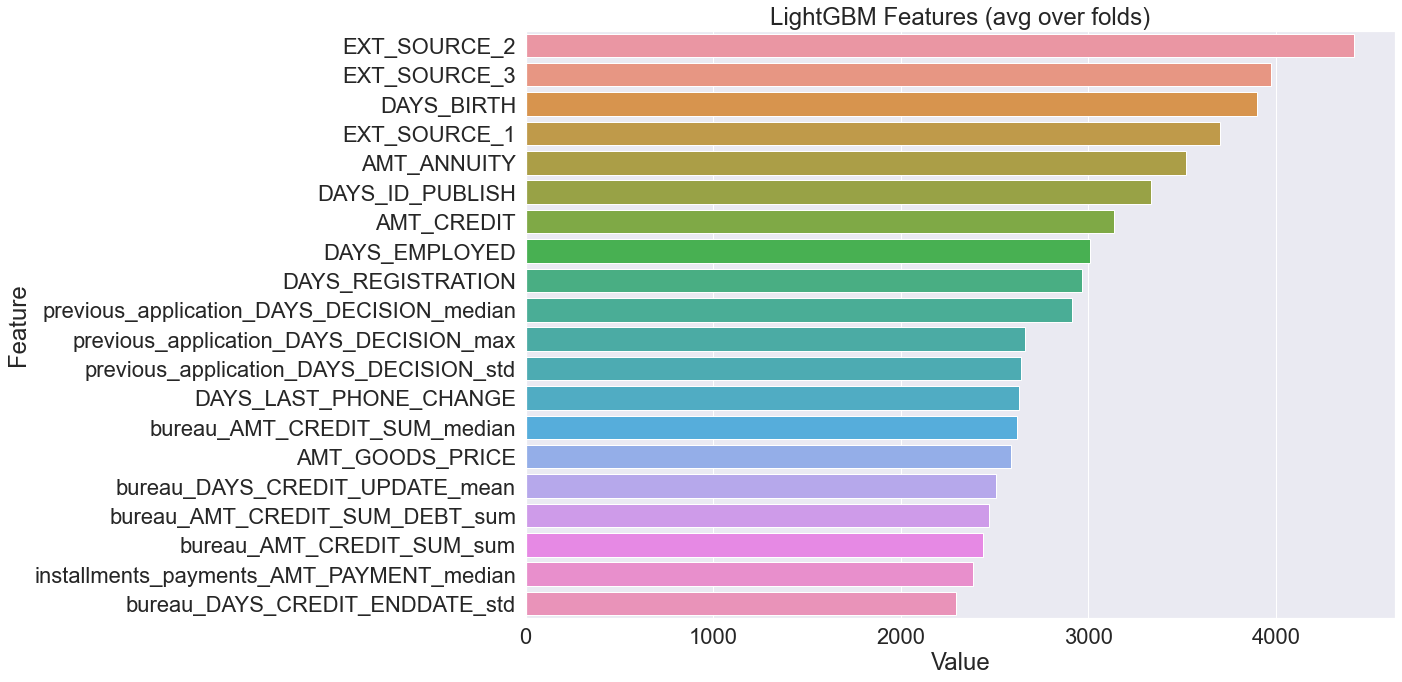

In [57]:
#print feature importance
feature_imp = pd.DataFrame({'Value':models[0].feature_importances_,'Feature':X_train.columns})
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                    ascending=False)[:20])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
#plt.savefig('lgbm_importances-01.png')
plt.show()